In [4]:
import os
import sys
import random
import PIL  
import cv2
from PIL import Image, ImageFilter
import numpy as np
import time

### ***L***e code

In [12]:
# chemin dossier contenant les images cleans

DATASET_PATH = os.path.join(os.getcwd(), "input") 

random_filename = random.choice([
    x for x in os.listdir(DATASET_PATH)
    if os.path.isfile(os.path.join(DATASET_PATH, x))
])
random_image = 'input/' + random_filename
new_file = 'output/' + random_filename

new_jpg = new_file
print(random_image)

input/000000000071.jpg


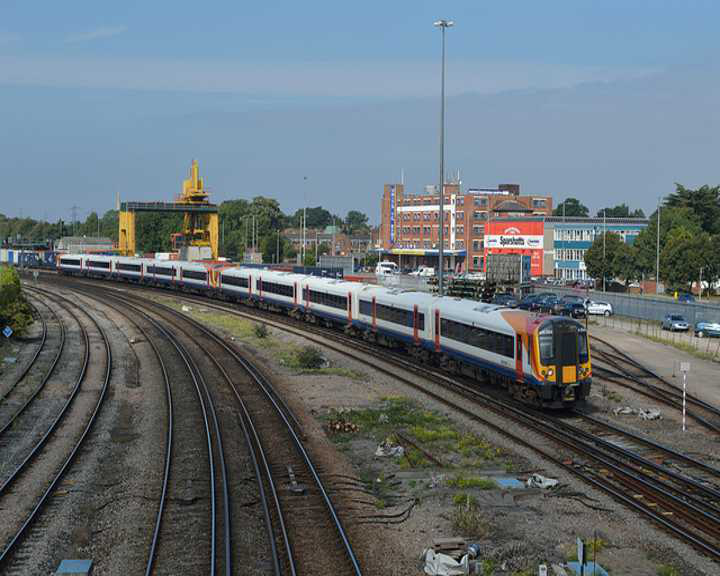

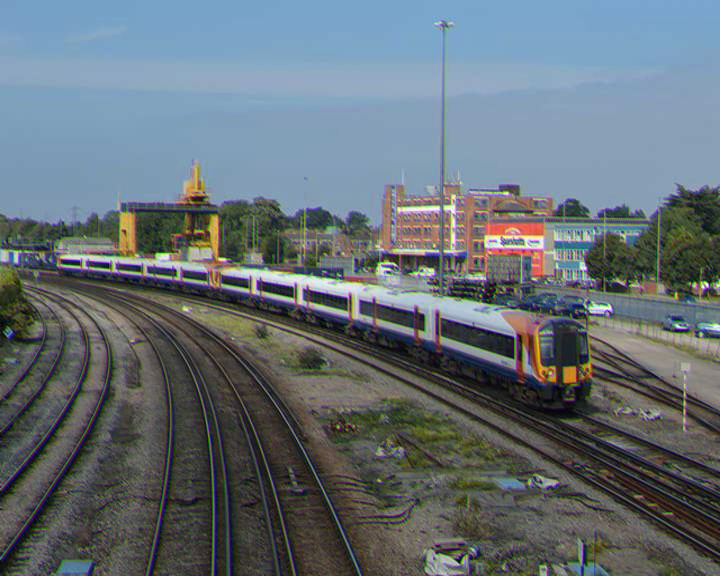

In [13]:
# import cv2
clean = Image.open(random_image)
display(clean)


image= cv2.imread(random_image, cv2.IMREAD_UNCHANGED)
addition = image

OFFSET = 1


def offsetSetting(R,G,B):
    red_layer = image[:,:,2]
    green_layer = image[:,:,1]
    blue_layer = image[:,:,0]

    #remettre au propre
    
    if (R == 0):
        addition[: ,: ,2] = red_layer[:,:]
        addition[G*OFFSET: ,G*OFFSET: ,1] = green_layer[:-G*OFFSET,:-G*OFFSET]
        addition[B*OFFSET: ,B*OFFSET: ,0] = blue_layer[:-B*OFFSET,:-B*OFFSET]
        cv2.imwrite(new_jpg,addition) 
    if (G == 0):
        addition[R*OFFSET: ,R*OFFSET: ,2] = red_layer[:-R*OFFSET,:-R*OFFSET]
        addition[: ,: ,1] = green_layer[:,:]
        addition[B*OFFSET: ,B*OFFSET: ,0] = blue_layer[:-B*OFFSET,:-B*OFFSET]
        cv2.imwrite(new_jpg,addition) 
        
    if (B == 0):
        addition[R*OFFSET: ,R*OFFSET: ,2] = red_layer[:-R*OFFSET,:-R*OFFSET]
        addition[G*OFFSET: ,G*OFFSET: ,1] = green_layer[:-G*OFFSET,:-G*OFFSET]
        addition[: ,: ,0] = blue_layer[:,:]
        cv2.imwrite(new_jpg,addition) 
        
        
offsetSetting(1, 0, 2)
addition_img = Image.open(new_file) 
display(addition_img)
